## Setting Up the Environment

First, let's import the necessary libraries and configure the environment.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import mne
import yaml
from pathlib import Path
import logging
import importlib

# Add the parent directory to path to import custom modules
sys.path.append(os.path.abspath('../..'))

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('fivepoint_pipeline')

# MNE settings
mne.set_log_level('INFO')
%matplotlib inline

## Loading the Pipeline Configuration

We'll load the minimal pipeline configuration from the YAML file.

In [2]:
# Load the minimal pipeline configuration
config_path = '../../configs/fivepoint_pipeline.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
print(f"Loaded configuration from {config_path}")

print("Pipeline steps:")
for step in config['pipeline']['steps']:
    print(f"- {step['name']}")

# Extract key configuration parameters
root_dir = config['directory']['root']
raw_data_dir = os.path.join(root_dir, config['directory']['raw_data_dir'])
processed_dir = os.path.join(root_dir, config['directory']['processed_dir'])
file_pattern = config['file_path_pattern']

# Ensure directories exist
os.makedirs(processed_dir, exist_ok=True)

Loaded configuration from ../../configs/fivepoint_pipeline.yml
Pipeline steps:
- LoadData
- PrepChannelsStep
- FilterStep
- EpochingStep
- SaveCheckpoint


## Step 1: Loading the Data

The first step is to load the raw EEG data. For Go/No-Go tasks, we expect the data to be in FIFF format.

2025-04-16 01:35:09,697 - root - WARNING - [ICAExtractionStep] PyQt5 not found, defaulting to Agg backend
2025-04-16 01:35:11,531 - root - INFO - [__init__.py] All step classes have been registered in STEP_REGISTRY.
2025-04-16 01:35:11,533 - fivepoint_pipeline - INFO - Loading data using LoadData


Extracting EDF parameters from E:\Yann\neurotheque_resources\data\pilot_data\sub-01_ses-001_task-5pt_run-01_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96599  =      0.000 ...   321.997 secs...

Raw data information:
Number of channels: 27
Sampling frequency: 300.0 Hz
Duration: 322.00 seconds
Using matplotlib as 2D backend.


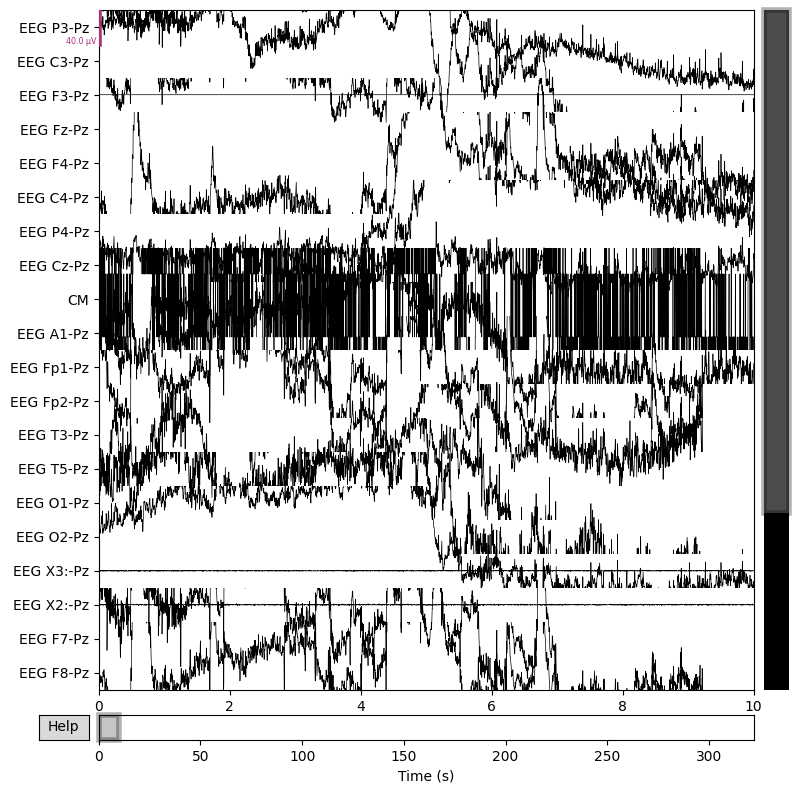

Channels marked as bad:
none
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [3]:
# Step 1: Loading the Data
# Extract loading parameters from the configuration
load_data_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'LoadData')

# Construct the file path
file_path = os.path.join(raw_data_dir, file_pattern)

# Import and use the LoadData class from the pipeline
from scr.steps.load import LoadData

# Create and apply the load data step
logger.info(f"Loading data using LoadData")
load_data_step = LoadData(params=load_data_config.get('params', {}))

# For LoadData step, we pass the file path in the params
load_params = load_data_step.params.copy()
load_params["input_file"] = file_path
load_data_step.params = load_params

raw = load_data_step.run(None)

# Display basic information about the raw data
print("\nRaw data information:")
print(f"Number of channels: {len(raw.ch_names)}")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.times[-1]:.2f} seconds")

%matplotlib TkAgg

# Plot the raw data (first 10 seconds)
raw.plot(duration=10, n_channels=20, title='Raw EEG data')

## Step 2: Channel Preparation

The `PrepChannelsStep` handles channel renaming, type setting, and montage application.

In [5]:
# Step 2: Channel Preparation
# Extract parameters from the configuration
prep_channels_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'PrepChannelsStep')

# Set the referencing parameters
if 'params' not in prep_channels_config:
    prep_channels_config['params'] = {}
    
prep_channels_config['params']['reference'] = {
    'method': 'average',  # Change from Pz (channels) to average reference
    'projection': False
}

# Force reload the module to ensure we have the latest version
import scr.steps.prepchannels
importlib.reload(scr.steps.prepchannels)

# Use the PrepChannelsStep with referencing
from scr.steps.prepchannels import PrepChannelsStep

# Create and apply the channel preparation step
logger.info(f"Preparing channels with referencing")
prep_channels_step = PrepChannelsStep(params=prep_channels_config['params'])
raw = prep_channels_step.run(raw)

# Print channel names after prep to verify ECG channel was dropped
print("\nChannel names after preparation:")
print(raw.ch_names)

2025-04-16 01:35:39,716 - fivepoint_pipeline - INFO - Preparing channels with referencing
2025-04-16 01:35:39,717 - root - INFO - [PrepChannelsStep] Running with params: {'on_missing': 'ignore', 'reference': {'method': 'average', 'projection': False}}
2025-04-16 01:35:39,733 - root - INFO - Dropped non-EEG: ['EEG X1:-Pz']
2025-04-16 01:35:39,736 - root - INFO - Renamed 18 EEG channels
e:\Yann\neurotheque_resources\scr\steps\prepchannels.py:53: RuntimeWarning: The unit for channel(s) Trigger has changed from NA to V.
  data.set_channel_types({ch: 'stim'})
2025-04-16 01:35:39,740 - root - INFO - Channel types set: 19 EEG, 1 STIM, 0 MISC
2025-04-16 01:35:39,741 - root - INFO - [PrepChannelsStep] Applying re-referencing with params: {'method': 'average', 'projection': False}
2025-04-16 01:35:39,742 - root - INFO - [apply_reference] Re-referencing method=average, projection=False
2025-04-16 01:35:39,743 - root - INFO - [apply_reference] Using average reference for EEG channels.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


2025-04-16 01:35:39,783 - root - INFO - [apply_reference] Re-reference complete.
2025-04-16 01:35:39,786 - root - INFO - [PrepChannelsStep] Re-referencing applied successfully
2025-04-16 01:35:39,806 - root - INFO - [PrepChannelsStep] Standard 10-20 montage applied
2025-04-16 01:35:39,809 - root - INFO - [PrepChannelsStep] Channels prepared successfully.



Channel names after preparation:
['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'Fp1', 'Fp2', 'T3', 'T5', 'O1', 'O2', 'F7', 'F8', 'T6', 'T4', 'Pz', 'Trigger']


## Step 3: Filtering

Filtering is a crucial step to remove unwanted frequency components from the signal. We apply:
1. A bandpass filter to remove slow drifts and high-frequency noise
2. Notch filters to remove power line interference

2025-04-16 01:40:20,241 - fivepoint_pipeline - INFO - Applying filtering using FilterStep


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 991 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 0.50 Hz
- Filter length: 1981 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 6.827 (s)
Plotting power spectral density (dB=True).


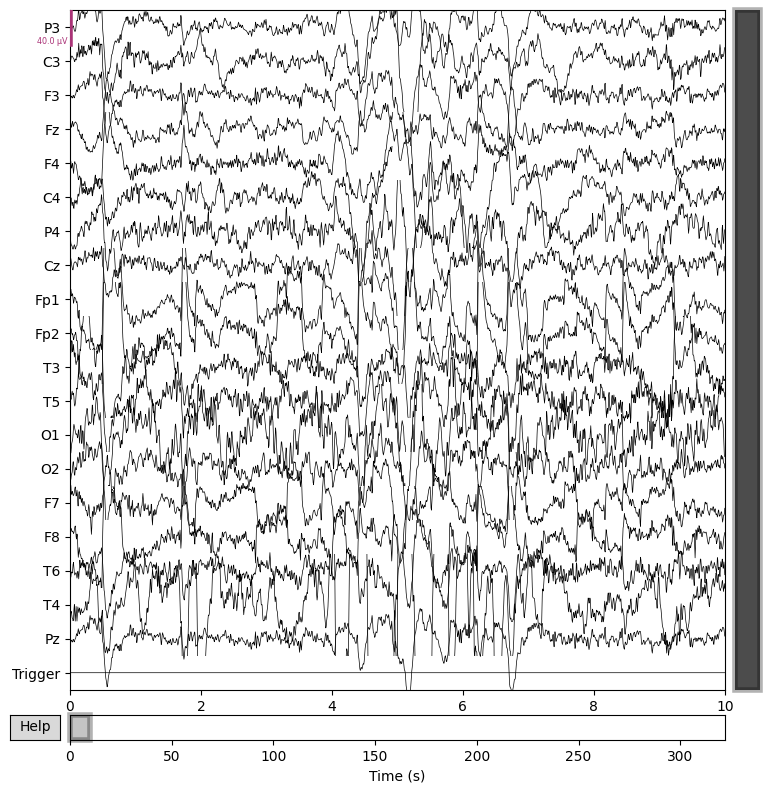

In [7]:
# Step 3: Filtering
# Extract filtering parameters from the configuration
filter_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'FilterStep')

# Use the FilterStep from the pipeline
from scr.steps.filter import FilterStep

# Create and apply the filter step
logger.info(f"Applying filtering using FilterStep")
filter_step = FilterStep(params=filter_config['params'])
raw = filter_step.run(raw)

# Plot power spectral density after filtering
fig, ax = plt.subplots(figsize=(10, 6))
raw.compute_psd(fmax=filter_config['params']['h_freq']*1.5, picks='eeg').plot(show=True)
ax.set_title('Power Spectral Density after Filtering')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dB)')
plt.show()

# Plot filtered data
raw.plot(duration=10, n_channels=20, title='Filtered EEG data')

## Advanced Spectral Analysis

Let's use the spectral analysis utilities to visualize the data in different ways.

In [8]:
# Example of using the spectral analysis utilities
from scr.utils.spectral import compute_and_plot_psd

# Plot standard PSD
logger.info("Plotting standard PSD")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=filter_config['params']['h_freq']*1.5,
                        picks='eeg',
                        plot_type='standard')
except Exception as e:
    logger.error(f"Error plotting standard PSD: {str(e)}")

# Plot average PSD across channels
logger.info("Plotting average PSD")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=filter_config['params']['h_freq']*1.5,
                        picks='eeg',
                        plot_type='average',
                        plot_kwargs={'color': 'blue', 'linewidth': 2})
except Exception as e:
    logger.error(f"Error plotting average PSD: {str(e)}")

# Plot PSD by frequency bands
logger.info("Plotting PSD by frequency bands")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=45,
                        picks='eeg',
                        plot_type='bands',
                        plot_kwargs={'bands': {
                            'delta': (1, 4),
                            'theta': (4, 8),
                            'alpha': (8, 13),
                            'beta': (13, 30),
                            'gamma': (30, 45)
                        }})
except Exception as e:
    logger.error(f"Error plotting PSD by frequency bands: {str(e)}")

2025-04-16 01:41:33,650 - fivepoint_pipeline - INFO - Plotting standard PSD
2025-04-16 01:41:33,651 - root - INFO - Computing PSD using welch method


Effective window size : 6.827 (s)


2025-04-16 01:41:33,736 - root - INFO - PSD shape: (19, 406), Freqs shape: (406,)


Plotting power spectral density (dB=True).


e:\Yann\neurotheque_resources\scr\utils\spectral.py:265: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
e:\Yann\neurotheque_resources\scr\utils\spectral.py:265: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2025-04-16 01:41:34,358 - fivepoint_pipeline - INFO - Plotting average PSD
2025-04-16 01:41:34,358 - root - INFO - Computing PSD using welch method


Effective window size : 6.827 (s)


2025-04-16 01:41:34,421 - root - INFO - PSD shape: (19, 406), Freqs shape: (406,)
2025-04-16 01:41:34,760 - fivepoint_pipeline - INFO - Plotting PSD by frequency bands
2025-04-16 01:41:34,763 - root - INFO - Computing PSD using welch method


Effective window size : 6.827 (s)


2025-04-16 01:41:34,830 - root - INFO - PSD shape: (19, 304), Freqs shape: (304,)


## Step 4: Epoching for Autoreject

For the five-point test, we'll create fixed-length epochs of 2 seconds duration without any baseline correction. This approach creates uniform time segments that are ideal for the autoreject algorithm, which can then identify and handle artifacts in a consistent way across the entire recording.

Instead of event-locked epochs, we're creating regular fixed-length segments (2 seconds each) throughout the recording. This method:
- Provides consistent coverage of the entire recording
- Creates uniform segments for artifact detection
- Works well when specific event markers aren't needed for analysis
- Is particularly effective for autoreject processing

In [13]:
# Step 4: Epoching
# Extract epoching parameters from the configuration
epoch_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'EpochingStep')

# Make sure required parameters are set
if 'params' not in epoch_config:
    epoch_config['params'] = {}

# Set critical parameters for fixed-length epochs for five-point task
epoch_config['params']['task_type'] = 'fixed'  # Use fixed-length epochs
epoch_config['params']['stim_channel'] = 'Trigger'  # Make sure stim channel is set

# Configure fixed-length epoch parameters
epoch_config['params']['epoch_params'] = {
    'duration': 2.0,      # 2-second epochs
    'overlap': 0.0,       # No overlap between segments
    'baseline': None,     # No baseline correction
    'preload': True,
    'reject_by_annotation': True
}

# Configure the event visualization
epoch_config['params']['visualize_events'] = True
epoch_config['params']['plot_params'] = {
    # Event visualization parameters
    'duration': 15.0,
    'tstart': 0.0,
    'interactive': True,
    'save_plots': True,
    'save_dir': os.path.join(processed_dir, 'figures/events')
}

# Log important parameters for reference
duration = epoch_config['params']['epoch_params']['duration']
overlap = epoch_config['params']['epoch_params']['overlap']
baseline = epoch_config['params']['epoch_params']['baseline']
stim_channel = epoch_config['params']['stim_channel']

print("\nFixed-length epoch parameters:")
print(f"- Duration: {duration}s")
print(f"- Overlap: {overlap}s")
print(f"- Baseline: {baseline}")

# Create and run the epoching step
from scr.steps.epoching import EpochingStep
logger.info(f"Creating fixed-length epochs of {duration}s duration with task_type={epoch_config['params']['task_type']}")
epoch_step = EpochingStep(params=epoch_config['params'])

# Run the epoching step
try:
    epochs = epoch_step.run(raw)

    # Display information about the epochs
    print("\nEpochs information:")
    print(epochs)

    # Use the generate_plots method with butterfly plot type (should work well)
    try:
        butterfly_plot = epoch_step.generate_plots(
            epochs,
            plot_params={
                'plot_type': 'butterfly',
                'event_names': ['fixed'],
                'channels': ['Fz', 'Cz', 'Pz'],
                'time_window': [0, 2.0],
                'save_plots': True,
                'save_dir': os.path.join(processed_dir, 'figures/epochs')
            }
        )
        print("Successfully generated butterfly plot")
    except Exception as e:
        print(f"Error generating butterfly plot: {str(e)}")
    
    # Try the average plot type with minimal parameters
    try:
        average_plot = epoch_step.generate_plots(
            epochs,
            plot_params={
                'plot_type': 'average',
                'event_names': ['fixed'],
                'channels': ['Fz', 'Cz', 'Pz'],
                # Avoid passing title which may cause issues
                'save_plots': True,
                'save_dir': os.path.join(processed_dir, 'figures/epochs')
            }
        )
        print("Successfully generated average plot")
    except Exception as e:
        print(f"Error generating average plot: {str(e)}")
    
    # Use direct MNE plotting methods as a fallback
    print("\nUsing MNE's native plotting methods...")
    
    # Plot a few channels from a few epochs
    fig1 = epochs.plot(picks=['Fz', 'Cz', 'Pz'], n_epochs=5, 
                      scalings='auto', 
                      title='Fixed-length 2s epochs')
    
    # Plot the average across all fixed epochs
    evoked = epochs.average()
    fig2 = evoked.plot(picks=['Fz', 'Cz', 'Pz'], 
                      titles='Average of fixed-length epochs')
    
    # Use the newer PSD method to avoid deprecation warnings
    fig3 = epochs.compute_psd().plot(picks=['Fz', 'Cz', 'Pz'], 
                                   average=True)
    
    # Save the figures
    save_dir = os.path.join(processed_dir, 'figures/epochs')
    os.makedirs(save_dir, exist_ok=True)
    
    fig1.savefig(os.path.join(save_dir, 'fixed_epochs_raw.png'))
    fig2.savefig(os.path.join(save_dir, 'fixed_epochs_average.png'))
    fig3.savefig(os.path.join(save_dir, 'fixed_epochs_psd.png'))
    
except Exception as e:
    logger.error(f"Error in epoching step: {str(e)}")

2025-04-16 02:05:16,273 - fivepoint_pipeline - INFO - Creating fixed-length epochs of 2.0s duration with task_type=fixed
2025-04-16 02:05:16,274 - root - INFO - [EpochingStep.__init__] Initialized with params: {'task_type': 'fixed', 'trigger_ids': {'go': 1, 'nogo': 2, 'response': 3}, 'epoch_params': {'duration': 2.0, 'overlap': 0.0, 'baseline': None, 'preload': True, 'reject_by_annotation': True}, 'stim_channel': 'Trigger', 'returns_epochs': True, 'visualize_events': True, 'plot_params': {'duration': 15.0, 'tstart': 0.0, 'interactive': True, 'save_plots': True, 'save_dir': 'E:/Yann/neurotheque_resources/data/processed\\figures/events'}}
2025-04-16 02:05:16,276 - root - INFO - [EpochingStep.run] Running with params: {'task_type': 'fixed', 'trigger_ids': {'go': 1, 'nogo': 2, 'response': 3}, 'epoch_params': {'duration': 2.0, 'overlap': 0.0, 'baseline': None, 'preload': True, 'reject_by_annotation': True}, 'stim_channel': 'Trigger', 'returns_epochs': True, 'visualize_events': True, 'plot_p


Fixed-length epoch parameters:
- Duration: 2.0s
- Overlap: 0.0s
- Baseline: None
Not setting metadata
161 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 161 events and 601 original time points ...
1 bad epochs dropped


2025-04-16 02:05:16,369 - root - INFO - [EpochingStep] Created 160 fixed-length epochs


Adding metadata with 0 columns

Epochs information:
<Epochs | 160 events (all good), 0 – 2 s (baseline off), ~14.7 MiB, data loaded, with metadata,
 'fixed': 160>


e:\Yann\neurotheque_resources\scr\steps\epoching.py:995: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2025-04-16 02:05:17,270 - root - INFO - [EpochingStep] Saved figure to E:\Yann\neurotheque_resources\data\processed\figures\epochs\sub-unknown_ses-001_plot-1.png


Successfully generated butterfly plot


e:\Yann\neurotheque_resources\scr\steps\epoching.py:977: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
e:\Yann\neurotheque_resources\scr\steps\epoching.py:977: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2025-04-16 02:05:18,171 - root - INFO - [EpochingStep] Saved figure to E:\Yann\neurotheque_resources\data\processed\figures\epochs\sub-unknown_ses-001_plot-1.png


Successfully generated average plot

Using MNE's native plotting methods...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


In [9]:
# Define output file path and save epochs

# Get save checkpoint step configuration from pipeline config
save_checkpoint_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'SaveCheckpoint')

# Import the SaveCheckpoint class from the pipeline steps
from scr.steps.save_checkpoint import SaveCheckpoint

# Create paths object from config if not already available
from scr.steps.project_paths import ProjectPaths
paths = ProjectPaths(config)

# Prepare parameters for SaveCheckpoint
save_params = save_checkpoint_config.get('params', {}).copy()

# Add required parameters
save_params.update({
    "subject_id": config.get('default_subject', '01'),
    "session_id": config.get('default_session', '001'),
    "task_id": "gng",
    "run_id": config.get('default_run', '01'),
    "checkpoint_key": "epoched",  # Customize the checkpoint name
    "paths": paths,
    "overwrite": True
})

# Create and run the SaveCheckpoint step
save_step = SaveCheckpoint(params=save_params)
save_step.run(epochs)

# Get the path for informational message
checkpoint_path = paths.get_checkpoint_path(
    subject_id=save_params["subject_id"],
    session_id=save_params["session_id"],
    task_id=save_params["task_id"],
    run_id=save_params["run_id"],
    checkpoint_name=save_params["checkpoint_key"]
)

print(f"\nPreprocessed epochs saved as checkpoint: {checkpoint_path}")



2025-04-14 16:17:33,148 - root - INFO - Saving checkpoint to: D:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_epoched.fif


Overwriting existing file.
Overwriting existing file.


d:\Yann\neurotheque_resources\scr\steps\save_checkpoint.py:26: RuntimeWarning: This filename (D:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  data.save(ckpt_path, overwrite=True)



Preprocessed epochs saved as checkpoint: D:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_epoched.fif


Channels marked as bad:
[np.str_('Pz')]


# Step 5: First AutoReject Pass
We now apply AutoReject to identify bad epochs from our fixed-length segments. AutoReject uses a machine learning approach to automatically detect and reject or repair problematic epochs, ensuring high data quality without subjective manual rejection.

In [ ]:
# Step 4: Epoching
# Extract epoching parameters from the configuration
epoch_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'EpochingStep')

# Make sure required parameters are set
if 'params' not in epoch_config:
    epoch_config['params'] = {}

# Set critical parameters for fixed-length epochs for five-point task
epoch_config['params']['task_type'] = 'fixed'  # Use fixed-length epochs
epoch_config['params']['stim_channel'] = 'Trigger'  # Make sure stim channel is set

# Configure fixed-length epoch parameters
epoch_config['params']['epoch_params'] = {
    'duration': 2.0,      # 2-second epochs
    'overlap': 0.0,       # No overlap between segments
    'baseline': None,     # No baseline correction - important for AutoReject
    'preload': True,
    'reject_by_annotation': True
}

# Configure the event visualization
epoch_config['params']['visualize_events'] = True
epoch_config['params']['plot_params'] = {
    # Event visualization parameters
    'duration': 15.0,
    'tstart': 0.0,
    'interactive': True,
    'save_plots': True,
    'save_dir': os.path.join(processed_dir, 'figures/events')
}

# Log important parameters for reference
duration = epoch_config['params']['epoch_params']['duration']
overlap = epoch_config['params']['epoch_params']['overlap']
baseline = epoch_config['params']['epoch_params']['baseline']
stim_channel = epoch_config['params']['stim_channel']

print("\nFixed-length epoch parameters:")
print(f"- Duration: {duration}s")
print(f"- Overlap: {overlap}s")
print(f"- Baseline: {baseline}")

# Create and run the epoching step
from scr.steps.epoching import EpochingStep
logger.info(f"Creating fixed-length epochs of {duration}s duration with task_type={epoch_config['params']['task_type']}")
epoch_step = EpochingStep(params=epoch_config['params'])

# Run the epoching step
try:
    epochs = epoch_step.run(raw)

    # Display information about the epochs
    print("\nEpochs information:")
    print(epochs)

    # Use direct MNE plotting to visualize the fixed-length epochs
    print("\nCreating visualizations of the fixed-length epochs...")
    
    # Save a figure showing a few epochs
    save_dir = os.path.join(processed_dir, 'figures/epochs')
    os.makedirs(save_dir, exist_ok=True)
    
    # Plot a few epochs
    fig1 = epochs.plot(picks=['Fz', 'Cz', 'Pz'], n_epochs=5, 
                     scalings='auto')
    fig1.savefig(os.path.join(save_dir, 'fixed_epochs_samples.png'))
    
    # Step 5: Apply AutoReject to identify bad epochs
    from scr.steps.autoreject import AutoRejectStep
    
    # Configure AutoReject parameters
    ar_params_dict = {
        "n_interpolate": None,  # Use default values
        "consensus": None,      # Use default values
        "thresh_method": "bayesian_optimization",
        "n_jobs": 1,
    }
    
    # Set up the AutoReject step parameters
    autoreject_dir = os.path.join(processed_dir, "autoreject")
    os.makedirs(autoreject_dir, exist_ok=True)
    
    autoreject_params = {
        "ar_params": ar_params_dict,
        "plot_results": True,  
        "interactive": True,   
        "mode": "fit",                  # Only identify bad epochs, don't clean yet
        "file_prefix": "ar_first_pass",
        "output_dir": os.path.join(processed_dir, "autoreject"),
        "plot_dir": autoreject_dir,     
        "store_reject_log": True,
        "save_model": False,            
        "subject_id": config.get('default_subject', '01'),
        "session_id": config.get('default_session', '001'),
        "run_id": config.get('default_run', '01'),
        "save_cleaned_data": False,     
    }
    
    # Create and run the AutoReject step
    logger.info("Applying AutoReject to identify bad epochs")
    autoreject_step = AutoRejectStep(params=autoreject_params)
    print(f"Data shape before AutoReject: {epochs.get_data().shape} (epochs x channels x time points)")
    epochs_with_ar = autoreject_step.run(epochs)
    
    # Display results
    if hasattr(epochs_with_ar, 'metadata') and 'ar_reject_log' in epochs_with_ar.metadata:
        reject_log = epochs_with_ar.metadata['ar_reject_log']
        n_bad_epochs = reject_log.bad_epochs.sum()
        percent_bad = (n_bad_epochs / len(epochs)) * 100
        print(f"\nAutoReject identified {n_bad_epochs} bad epochs ({percent_bad:.1f}% of total)")
    
except Exception as e:
    logger.error(f"Error in processing pipeline: {str(e)}")